<a href="https://colab.research.google.com/github/rohan1907/StumbleUpon-Evergreen-Classification-Challenge/blob/main/StumbleUpon%20Evergreen%20Classification%20Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

import tensorflow as tf 

In [4]:
!pip install transformers

     |████████████████████████████████| 1.8MB 9.3MB/s 
     |████████████████████████████████| 890kB 16.3MB/s 
     |████████████████████████████████| 3.2MB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=835780958fa3cc5963140f03cbaa01e8fc3fd1b7ea3f40cdabaf296ab00f2a11
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [13]:
# taking all columns of training set only for data exploration
df_train=pd.read_csv('/content/data/train.tsv',sep='\t')
# taking boilerplate column as an input for the model beacuse only this column contain lot of high quality text data useful for our nlp task
df_test=pd.read_csv('/content/data/test.tsv',sep='\t', usecols=['urlid','boilerplate'])


In [16]:
df_train.columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label'],
      dtype='object')

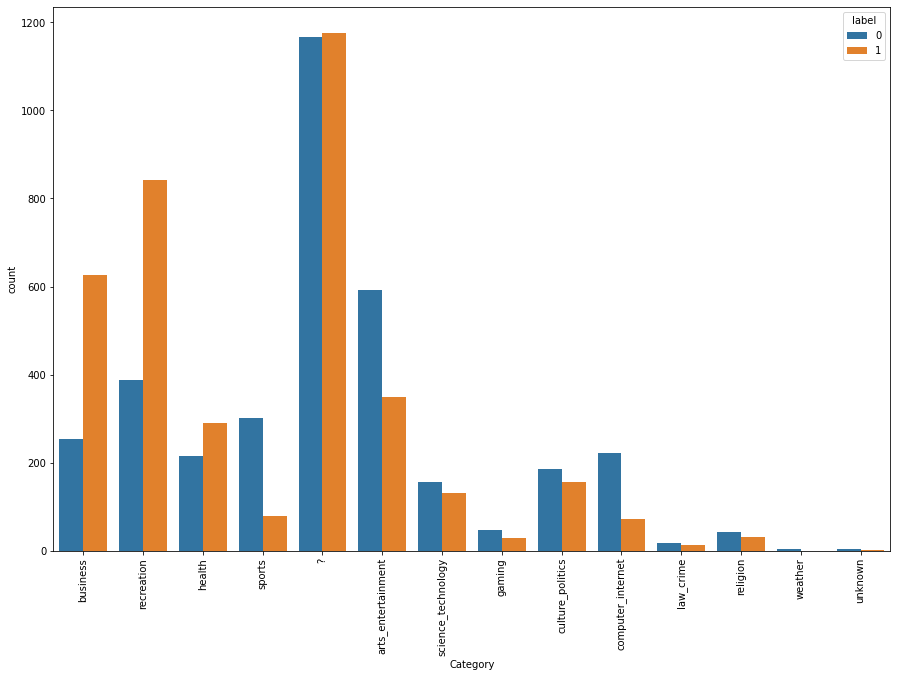

In [17]:
plt.figure(figsize=(15,10))
sns.countplot(x=df_train['alchemy_category'],hue=df_train['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

In [18]:
df_train['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_train['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_train['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_train['boilerplate']=df_train['boilerplate'].str.lower()


#Cleaning the test dataframe 

df_test['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_test['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_test['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_test['boilerplate']=df_test['boilerplate'].str.lower()

In [19]:
from transformers import AutoTokenizer


#Downloading the tokenizer and the Albert model for fine tuning

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [20]:
#ADD all the variable for the Transformer model 
# because bert base uncased Model can only handle upto 512 tokens at a time
SEQ_length=512

#Lets create the X and Y matrix from the Df train set 

Xids=np.zeros((df_train.shape[0],SEQ_length))
Xmask=np.zeros((df_train.shape[0],SEQ_length))
y=np.zeros((df_train.shape[0],1))

#Preparing the test dataframe

Xids_test=np.zeros((df_test.shape[0],SEQ_length))
Xmask_test=np.zeros((df_test.shape[0],SEQ_length))
Xids

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
for i,sequence in enumerate(df_train['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids[i,:],Xmask[i,:],y[i,0]=tokens['input_ids'],tokens['attention_mask'],df_train.loc[i,'label']
    

for i,sequence in enumerate(df_test['boilerplate']):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids_test[i,:],Xmask_test[i,:]=tokens['input_ids'],tokens['attention_mask']

In [22]:
Xids.shape

(7395, 512)

In [23]:
dataset=tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))

def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask},labels

dataset=dataset.map(map_func)
dataset=dataset.shuffle(100000).batch(32).prefetch(1000)

DS_size=len(list(dataset))

train=dataset.take(round(DS_size*0.85))
val=dataset.skip(round(DS_size*0.85))

In [24]:
#Preparing the test dataset

dataset_test=tf.data.Dataset.from_tensor_slices((Xids_test,Xmask_test))

def map_func(input_ids,mask):
    return {'input_ids':input_ids,'attention_mask':mask}

dataset_test=dataset_test.map(map_func)
dataset_test=dataset_test.batch(32).prefetch(1000)

In [25]:
from transformers import TFDistilBertModel, DistilBertConfig
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

input_ids_in = tf.keras.layers.Input(shape=(SEQ_length,), name='input_ids', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(SEQ_length,), name='attention_mask', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(1, activation='softmax')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
  layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fb1ed6702a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fb1ed6702a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512, 100)     327600      tf_distil_bert_model[0][0]   

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
])

In [ ]:
history=model.fit(train,validation_data=val,epochs=5)

Epoch 1/5
116/197 [================>.............] - ETA: 5:03 - loss: 0.5628 - auc: 0.5000 - precision: 0.5128 - recall: 1.0000

In [ ]:
predictions=model.predict(dataset_test)